In [9]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
# Load Dataset
df = pd.read_csv("cleaned_wait_times.csv")
df.head(10)

,Reporting level,Province,Region,Indicator,Metric,Data year,Unit of measurement,Indicator result
0,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,50th Percentile,2008,Days,25.0
1,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,90th Percentile,2008,Days,60.0
2,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,Volume,2008,Number of cases,254.0
3,Provincial,Alberta,Calgary Zone,Breast Cancer Surgery,50th Percentile,2008,Days,19.0
4,Provincial,Alberta,Calgary Zone,Breast Cancer Surgery,90th Percentile,2008,Days,42.0
5,Provincial,Alberta,Calgary Zone,Breast Cancer Surgery,Volume,2008,Number of cases,333.0
6,Provincial,Alberta,Calgary Zone,CABG,% Meeting Benchmark,2008,Proportion,99.0
7,Provincial,Alberta,Calgary Zone,CABG,50th Percentile,2008,Days,7.0
8,Provincial,Alberta,Calgary Zone,CABG,90th Percentile,2008,Days,83.0
9,Provincial,Alberta,Calgary Zone,CABG,Volume,2008,Number of cases,208.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Reporting level      12600 non-null  object 
 1   Province             12600 non-null  object 
 2   Region               12600 non-null  object 
 3   Indicator            12600 non-null  object 
 4   Metric               12600 non-null  object 
 5   Data year            12600 non-null  int64  
 6   Unit of measurement  12600 non-null  object 
 7   Indicator result     12600 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 787.6+ KB


In [12]:
df.describe()

,Data year,Indicator result
count,12600.000000,12600.000000
mean,2016.719048,169.887189
std,4.262085,176.773169
min,2008.000000,0.420000
25%,2014.000000,49.000000
50%,2017.000000,97.000000
75%,2020.000000,242.000000
max,2023.000000,998.000000


In [13]:
df.isnull().sum()

Reporting level        0
Province               0
Region                 0
Indicator              0
Metric                 0
Data year              0
Unit of measurement    0
Indicator result       0
dtype: int64

In [30]:
# ----------------------------------------
# HYPOTHESIS 3.2.1: Differences by Province
# ----------------------------------------
df_50th = df[(df['Metric'] == '50th Percentile') & (df['Data year'] == 2023)]

# ANOVA by Province
province_groups = [group['Indicator result'].dropna().values for _, group in df_50th.groupby('Province')]
f_stat, p_val = stats.f_oneway(*province_groups)
print("3.2.1 ANOVA (Province) => F-statistic:", f_stat, ", p-value:", p_val)

# Tukey HSD (Province)
province_tukey = pairwise_tukeyhsd(df_50th['Indicator result'], df_50th['Province'], alpha=0.05)
print(province_tukey.summary())

3.2.1 ANOVA (Province) => F-statistic: 1.9548078491037453 , p-value: 0.044931627496171314
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
          group1                    group2          meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------------------------------
                  Alberta          British Columbia   0.1437    1.0  -99.4722  99.7597  False
                  Alberta                  Manitoba   4.1192    1.0  -95.4968 103.7351  False
                  Alberta             New Brunswick -12.3371    1.0 -119.9346  95.2605  False
                  Alberta Newfoundland and Labrador  26.7029 0.9979  -75.1519 128.5577  False
                  Alberta               Nova Scotia  10.9202    1.0  -90.9346  112.775  False
                  Alberta                   Ontario -20.6973 0.9991 -108.9974  67.6028  False
                  Alberta      Prince Edward Island -24.5196 0.9

In [42]:
# ----------------------------------------
# HYPOTHESIS 3.2.2: Differences by Procedure
# ----------------------------------------
# Filter for 90th Percentile and year 2023
df_90th = df[(df['Metric'] == '90th Percentile') & (df['Data year'] == 2023)].copy()
df_90th = df_90th[['Indicator', 'Indicator result']].dropna()

# Step 1: ANOVA Test
procedure_groups = [group['Indicator result'].values for _, group in df_90th.groupby('Indicator') if len(group) > 1]
f_stat, p_val = stats.f_oneway(*procedure_groups)
print("ANOVA Results (90th Percentile):")
print(f"F-statistic = {f_stat:.2f}, p-value = {p_val:.2e}")

# Step 2: Tukey HSD test
tukey_result = pairwise_tukeyhsd(endog=df_90th['Indicator result'],
                                 groups=df_90th['Indicator'],
                                 alpha=0.05)

# Convert Tukey result to DataFrame
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
tukey_df[['meandiff', 'lower', 'upper']] = tukey_df[['meandiff', 'lower', 'upper']].astype(float)
tukey_df['reject'] = tukey_df['reject'].astype(bool)
print(tukey_result.summary())

ANOVA Results (90th Percentile):
F-statistic = 35.38, p-value = 9.40e-50
                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                        
                   group1                                      group2                    meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------------------------------------------------------------------
                     Bladder Cancer Surgery                       Breast Cancer Surgery     -21.1    1.0 -221.9203  179.7203  False
                     Bladder Cancer Surgery                                        CABG       4.9    1.0 -195.9203  205.7203  False
                     Bladder Cancer Surgery                                     CT Scan      64.7 0.9982 -136.1203  265.5203  False
                     Bladder Cancer Surgery                            Cataract surgery     232.9 0.0082   32.0797  433.7203   True
   

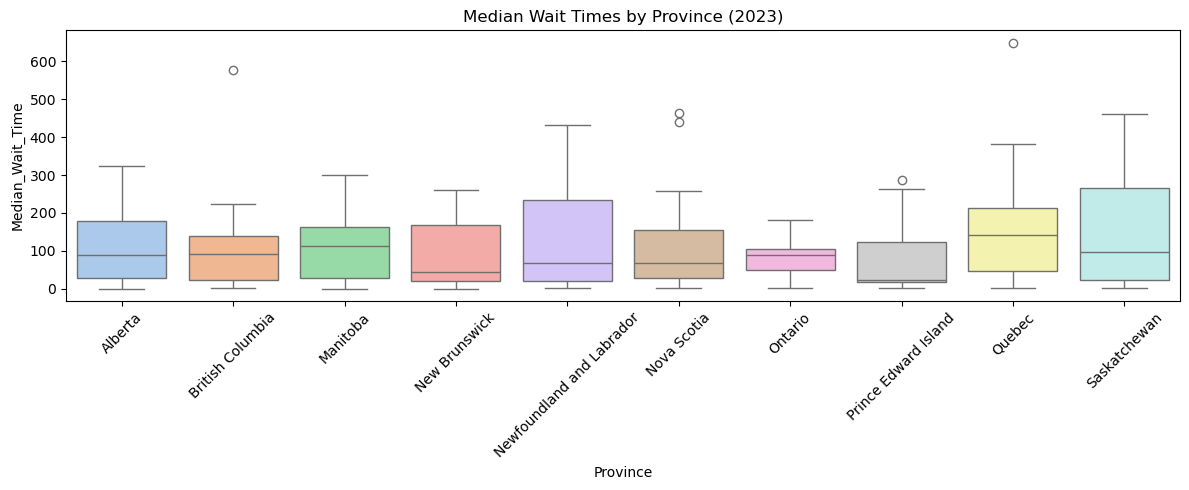

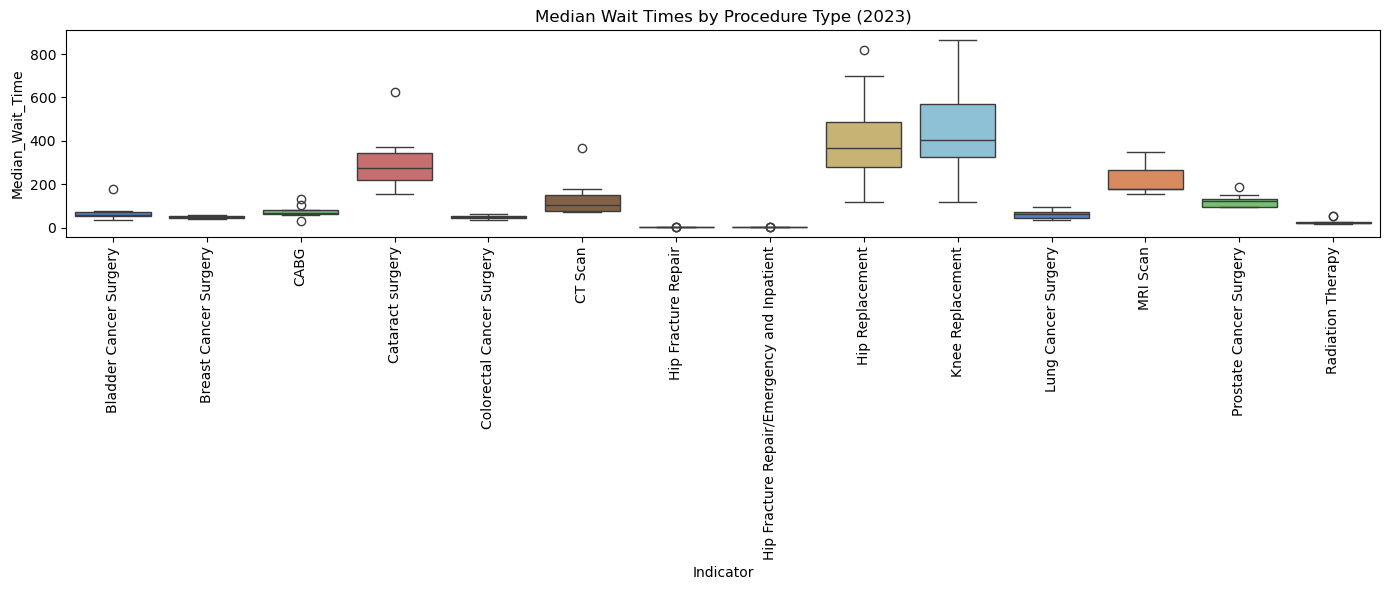

In [40]:
# Filter and rename for clarity
df_plot = df[(df['Metric'] == '50th Percentile') & (df['Data year'] == 2023)].copy()
df_plot_50th = df_plot.rename(columns={"Indicator result": "Median_Wait_Time"})

# Boxplot: Median wait times across provinces
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_plot_50th, x="Province", y="Median_Wait_Time", hue="Province", palette="pastel", legend=False)
plt.title("Median Wait Times by Province (2023)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Filter and rename for clarity
df_plot = df[(df['Metric'] == '90th Percentile') & (df['Data year'] == 2023)].copy()
df_plot_90th = df_plot.rename(columns={"Indicator result": "Median_Wait_Time"})
# Boxplot: Median wait times across procedures
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_90th, x="Indicator", y="Median_Wait_Time", hue="Indicator", palette="muted", legend=False)
plt.title("Median Wait Times by Procedure Type (2023)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
## ----------------------------------------
# PREDICTIVE MODELING: Median Wait Time
# ----------------------------------------
df_model = df[df['Metric'] == '90th Percentile'].copy()
df_model = df_model[['Province', 'Region', 'Indicator', 'Data year', 'Indicator result']].dropna()

# Encode Categorical Features
le_province = LabelEncoder()
le_region = LabelEncoder()
le_indicator = LabelEncoder()

df_model['Province_enc'] = le_province.fit_transform(df_model['Province'])
df_model['Region_enc'] = le_region.fit_transform(df_model['Region'])
df_model['Indicator_enc'] = le_indicator.fit_transform(df_model['Indicator'])

# Define X and y
X = df_model[['Province_enc', 'Region_enc', 'Indicator_enc', 'Data year']]
y = df_model['Indicator result']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("Model Performance:")
print("MAE:", round(mae, 2), "days")
print("RMSE:", round(rmse, 2), "days")

Model Performance:
MAE: 31.13 days
RMSE: 57.23 days


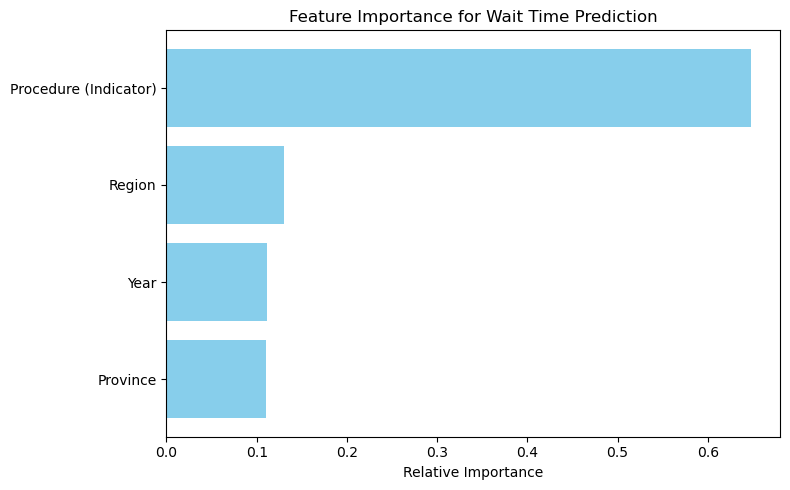

In [18]:
# Feature Importance Plot
feature_importance = pd.DataFrame({
    'Feature': ['Province', 'Region', 'Procedure (Indicator)', 'Year'],
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.title("Feature Importance for Wait Time Prediction")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()